In [13]:
# configuration parameters for Times square
last_data_date = 'Now'
duration_in_day = 1
OverViewOnly = True

In [14]:
from matplotlib import pyplot as plt

from lsst_efd_client import EfdClient,resample
import numpy as np
import pandas as pd
import datetime 
import pytz
timezone = pytz.utc
from math import isnan
import asyncio


In [15]:
# initialisation from 
if last_data_date == 'Now':
    last_data_date_val = datetime.datetime.now(datetime.UTC)
else:
    last_data_date_val = datetime.datetime.fromisoformat(last_data_date+'T00:00:00+00:00')
first_data_date_val = last_data_date_val - datetime.timedelta(days=duration_in_day)
#
tstart=first_data_date_val.isoformat()
tend=last_data_date_val.isoformat()
# save plot on file
save_fig=False
# show plot on screen 
show_it = True
#
day_ref=datetime.datetime.fromisoformat(tstart).replace(tzinfo=None)
print( 'we will analyse data between ',tstart,' and ',tend,' using FES configuration at ', day_ref)
run_cur='%s_%s' % (first_data_date_val.isoformat(),last_data_date_val.isoformat())
#
# ------------- initialisation 
# --- Manual configuration  ( to be edited by hand )  
#
#
output_data='/home/a/antilog/public_html/LsstCam/fes/'
#
# --- Automated configuration 
client = EfdClient('usdf_efd')
#
if save_fig  :
    print('Output will be saved in %s%s' % (output_data,run_cur))
#---------
manual=False
#
socket_name=[]
for i in range(5) : 
    socket_name.append('socket%d' % (i+1))
#


we will analyse data between  2025-11-29T19:47:23.428997+00:00  and  2025-11-30T19:47:23.428997+00:00  using FES configuration at  2025-11-29 19:47:23.428997


In [16]:
#
def SaveFig(fig,File,run_cur='',raft_cur='',ccd_cur='',hdu=''):
    if len(hdu)==0 : 
        root_plt=os.path.join(output_data,run_cur,raft_cur,ccd_cur)
    else : 
        hdu_cur='%s' % (hdu)
        root_plt=os.path.join(output_data,run_cur,raft_cur,ccd_cur,hdu_cur)
    # 
    PlotFile=File.replace('.','_')
    PlotFile=PlotFile.replace(' ','_')
    os.makedirs(root_plt,exist_ok=True)
    plotfile=os.path.join(root_plt,PlotFile)
    print ('PlotFile=',plotfile)
    fig.savefig(plotfile,bbox_inches='tight')
    plt.close(fig) 
    return


In [17]:
async def read_db(query,verbose=False,clean=True) :
    if verbose : print(query)
    db_in =  await client.influx_client.query(query)
    for col in db_in.columns :
        len_col=len(db_in[db_in[col].notnull()])
        if clean :
            if len_col==0 : 
                db_in.drop(columns=[col],inplace=True)
                txt='dropped'
            else :
                txt='kept'
        else :
            txt='kept'  
        if verbose : print('%s (%s) = %d ' % (col,txt,len_col) )
    return db_in 

In [18]:
#
query = '''SELECT * FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.fcs_duration_carousel_clamps" WHERE  time > '%s' AND time < '%s' AND "Agent"='fcs' AND "Hardware"='carousel' ''' % (tstart,tend)
cl_duration  =  await read_db(query,clean=False)
#
query = '''SELECT * FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.fcs_duration" WHERE  time > '%s' AND time < '%s' AND "Agent"='fcs'  ''' % (tstart,tend)
set_duration  = await read_db(query,clean=False)
#
query = '''SELECT * FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.fcs_counters" WHERE  time > '%s' AND time < '%s' AND "Agent"='fcs'  ''' % (tstart,tend)
set_counter  = await read_db(query,clean=False)
#
counter_all=pd.merge_asof(cl_duration,set_counter[set_counter['SET_FILTER'].notnull()]['SET_FILTER'],left_index=True, right_index=True,suffixes=('_cl', ''), tolerance=pd.Timedelta("200s"),direction='backward' )
duration_all=pd.merge_asof(counter_all,set_duration[set_duration['SET_FILTER'].notnull()]['SET_FILTER'],left_index=True, right_index=True,suffixes=('_count', ''), tolerance=pd.Timedelta("200s"),direction='forward' )


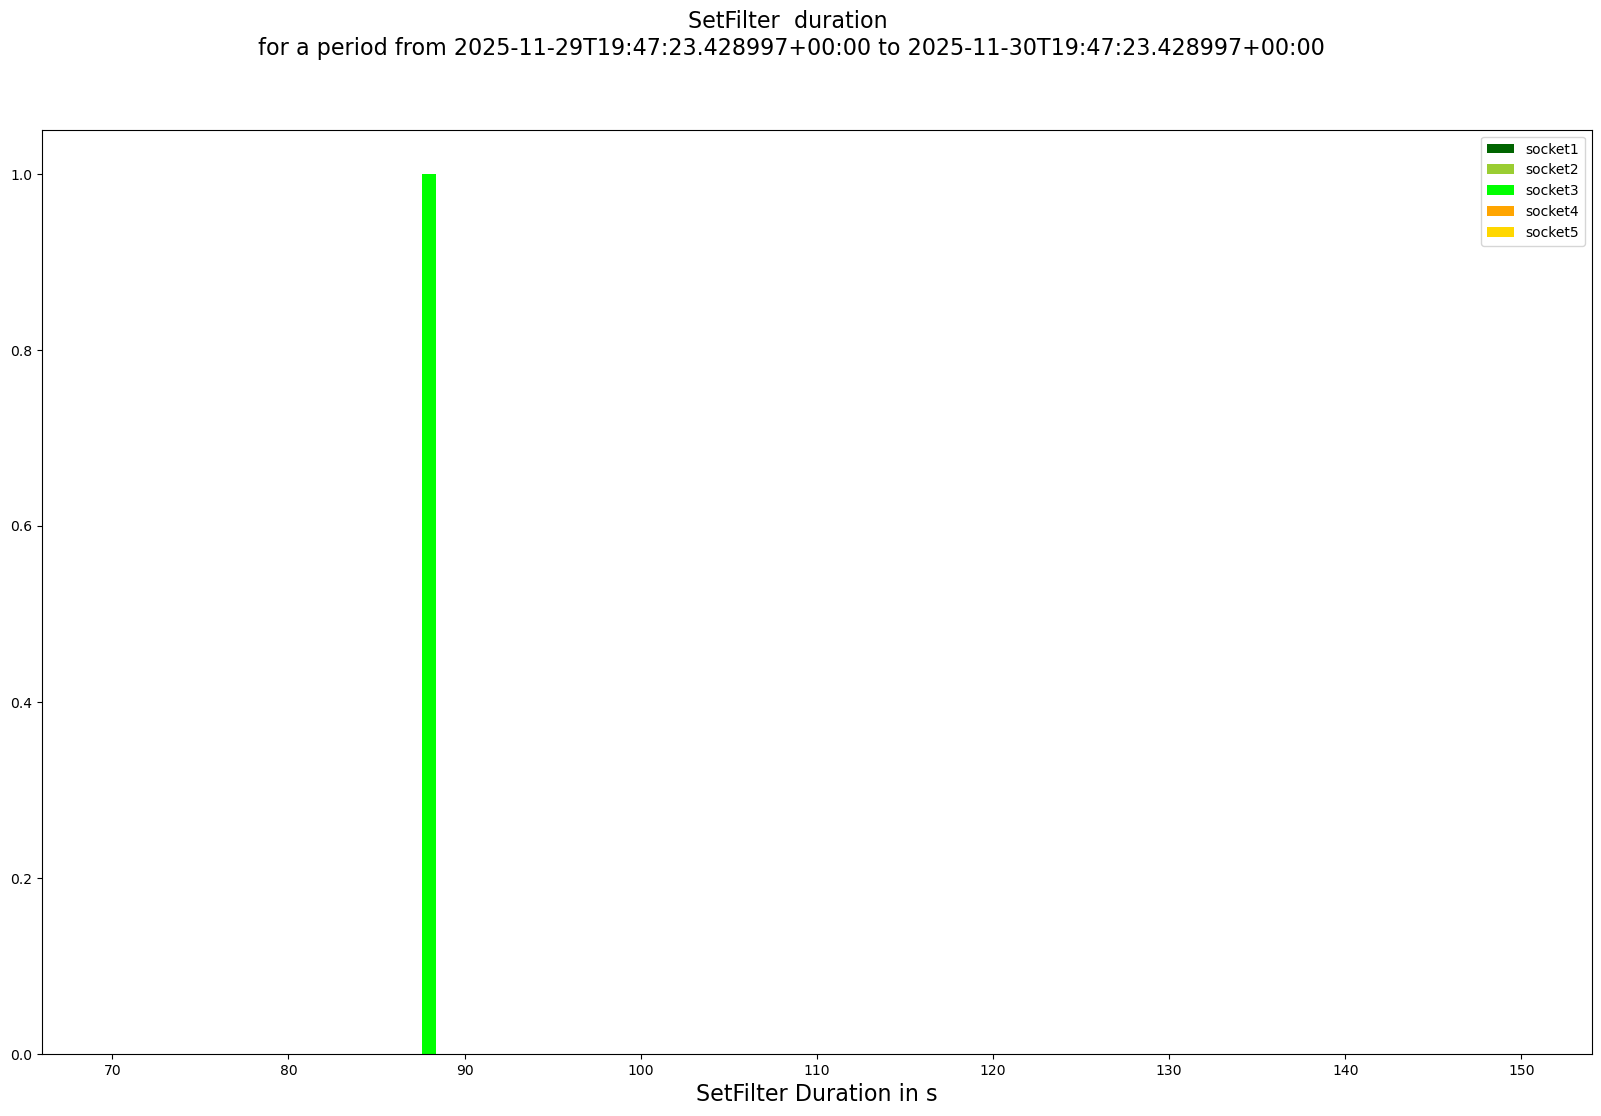

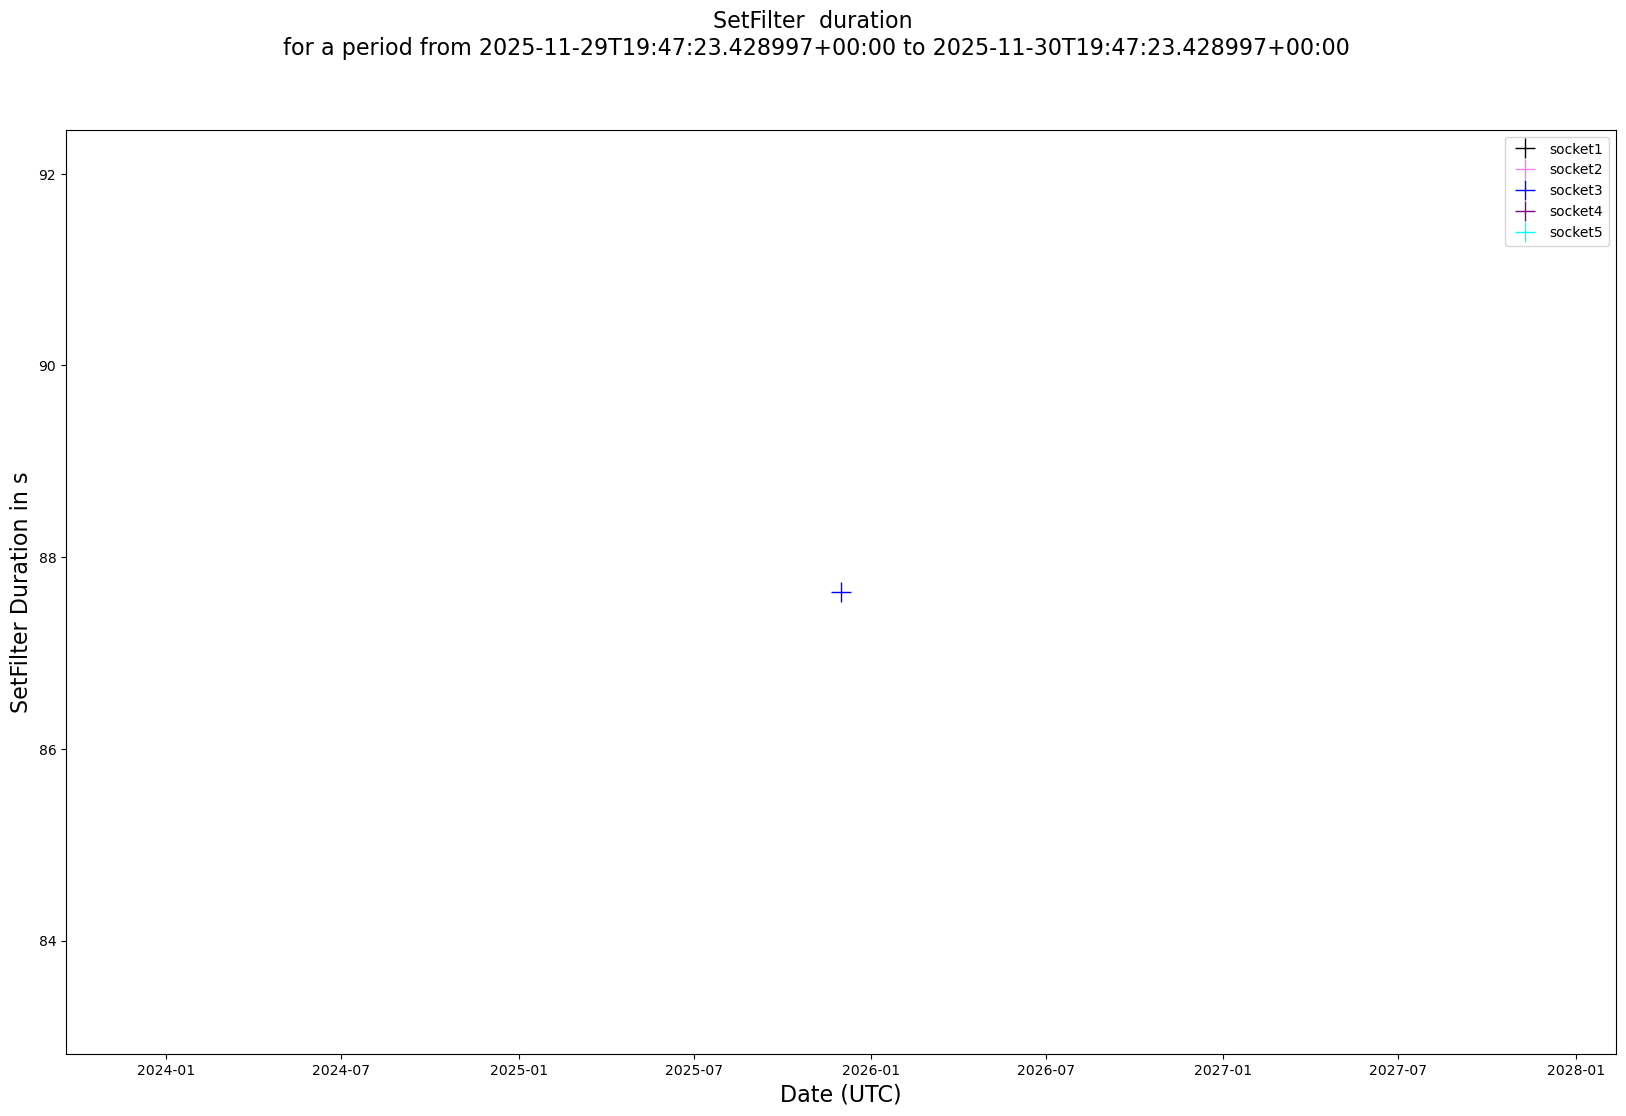

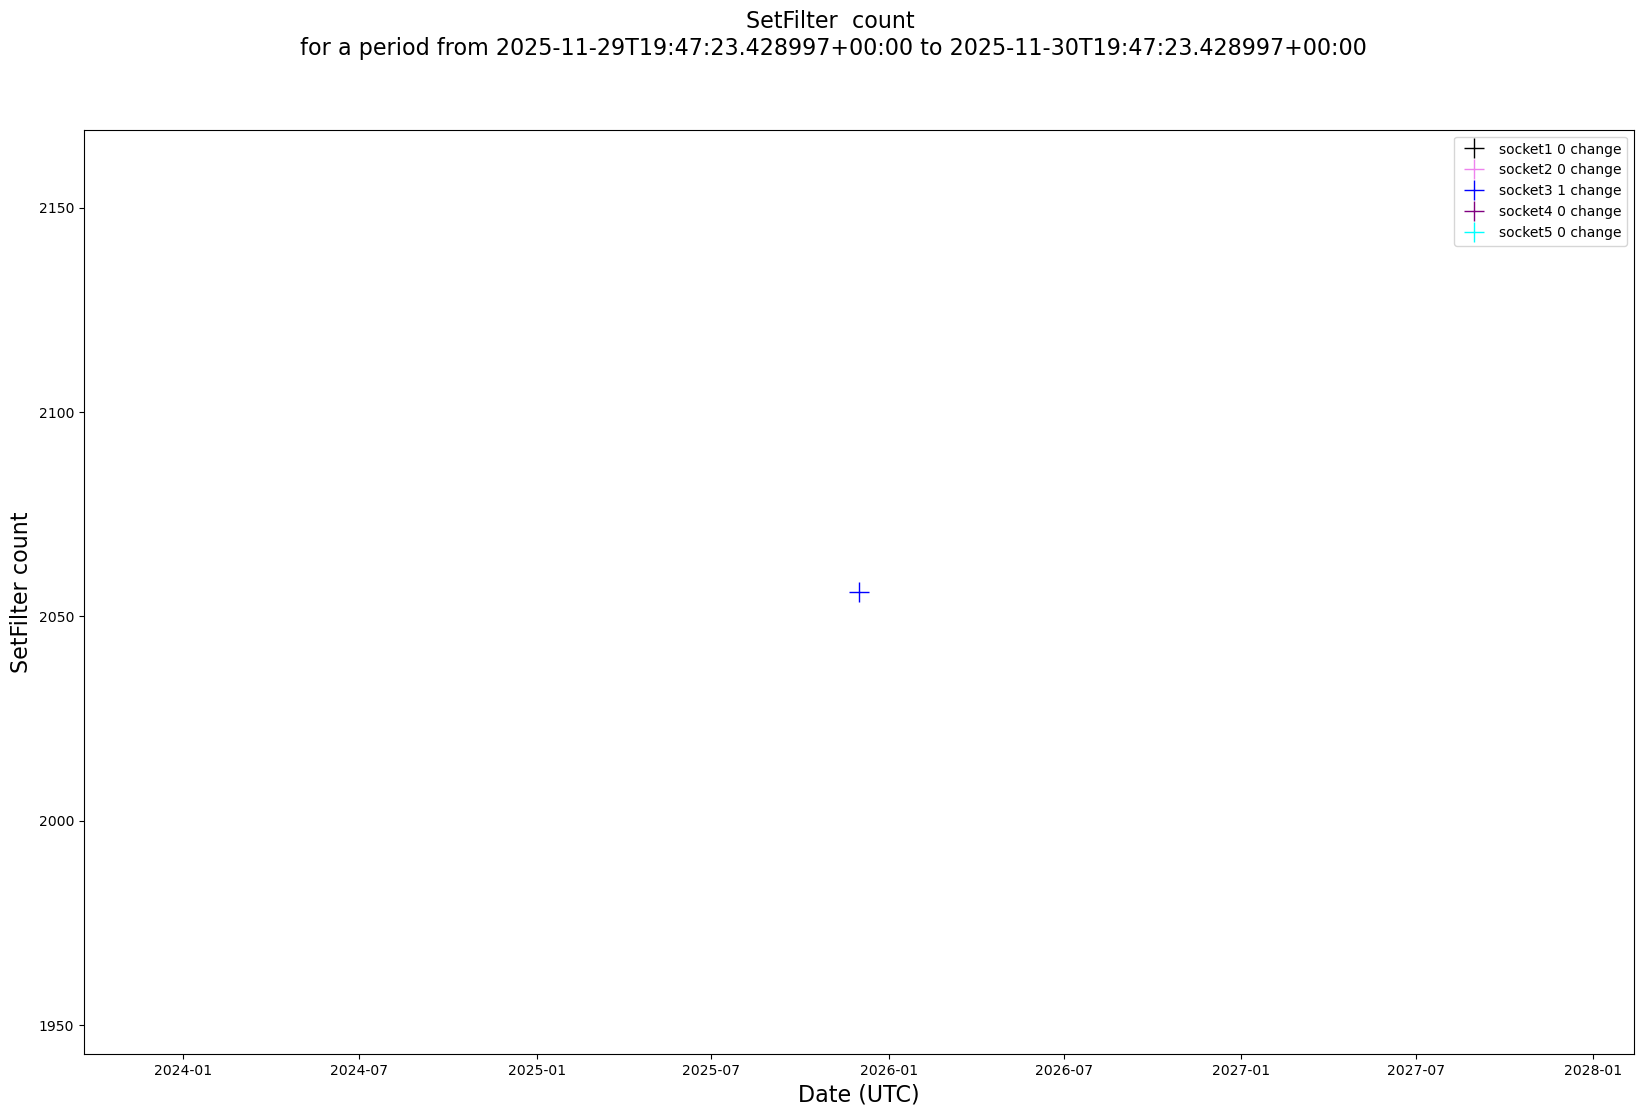

In [19]:
# Duration Plots 
color={'Xplus':['black','violet','b','purple','cyan'],'Xminus':['darkgreen','yellowgreen','lime','orange','gold']}
sym={'Xplus':'+','Xminus':'_'}
#
#
fig=plt.figure(figsize=(20,12))
title='SetFilter  duration \n for a period from %s to %s ' % (tstart,tend)
fig.suptitle(title,fontsize=16)
a=[]
label=[]
for isock in range(1,6) : 
    for car_clamp in ['Xminus'] :
        a.append(duration_all[(duration_all['UNLOCK'].notnull()) & (duration_all['Socket']==socket_name[isock-1] )& (duration_all['Clamp']==car_clamp )]['SET_FILTER']/1000.)
        label.append(socket_name[isock-1])
plt.hist(a,100,range=(70,150),stacked=True,color=color[car_clamp],label=label)
plt.xlabel('SetFilter Duration in s',fontsize=16) 
plt.legend()
if show_it : plt.show()
if save_fig : SaveFig(fig,File='SetFilterDurationHist',run_cur=run_cur,raft_cur='ClampOnCarousel')
#
fig=plt.figure(figsize=(20,12))
title='SetFilter  duration \n for a period from %s to %s ' % (tstart,tend)
fig.suptitle(title,fontsize=16)
for isock in range(1,6) : 
    for car_clamp in ['Xplus'] :
        plt.plot(duration_all[(duration_all['UNLOCK'].notnull()) & (duration_all['Socket']==socket_name[isock-1] )& (duration_all['Clamp']==car_clamp )]['SET_FILTER']/1000.,' ',marker=sym[car_clamp],color=color[car_clamp][isock-1],markersize=14,label=socket_name[isock-1])
plt.xlabel('Date (UTC)',fontsize=16)
plt.ylabel('SetFilter Duration in s',fontsize=16) 
plt.legend()
if show_it : plt.show()
if save_fig : SaveFig(fig,File='SetFilterDuration',run_cur=run_cur,raft_cur='ClampOnCarousel')
#
fig=plt.figure(figsize=(20,12))
title='SetFilter  count \n for a period from %s to %s ' % (tstart,tend)
fig.suptitle(title,fontsize=16)
for isock in range(1,6) : 
    for car_clamp in ['Xplus'] :
        nb_sock=len(duration_all[(duration_all['UNLOCK'].notnull()) & (duration_all['Socket']==socket_name[isock-1] )& (duration_all['Clamp']==car_clamp )]['SET_FILTER_count'])
        label_count='%s %d change' % (socket_name[isock-1],nb_sock)
        plt.plot(duration_all[(duration_all['UNLOCK'].notnull()) & (duration_all['Socket']==socket_name[isock-1] )& (duration_all['Clamp']==car_clamp )]['SET_FILTER_count'],' ',marker=sym[car_clamp],color=color[car_clamp][isock-1],markersize=14,label=label_count)
plt.xlabel('Date (UTC)',fontsize=16)
plt.ylabel('SetFilter count',fontsize=16) 
plt.legend()
if show_it : plt.show()
if save_fig : SaveFig(fig,File='SetFilterCount',run_cur=run_cur,raft_cur='ClampOnCarousel')
#



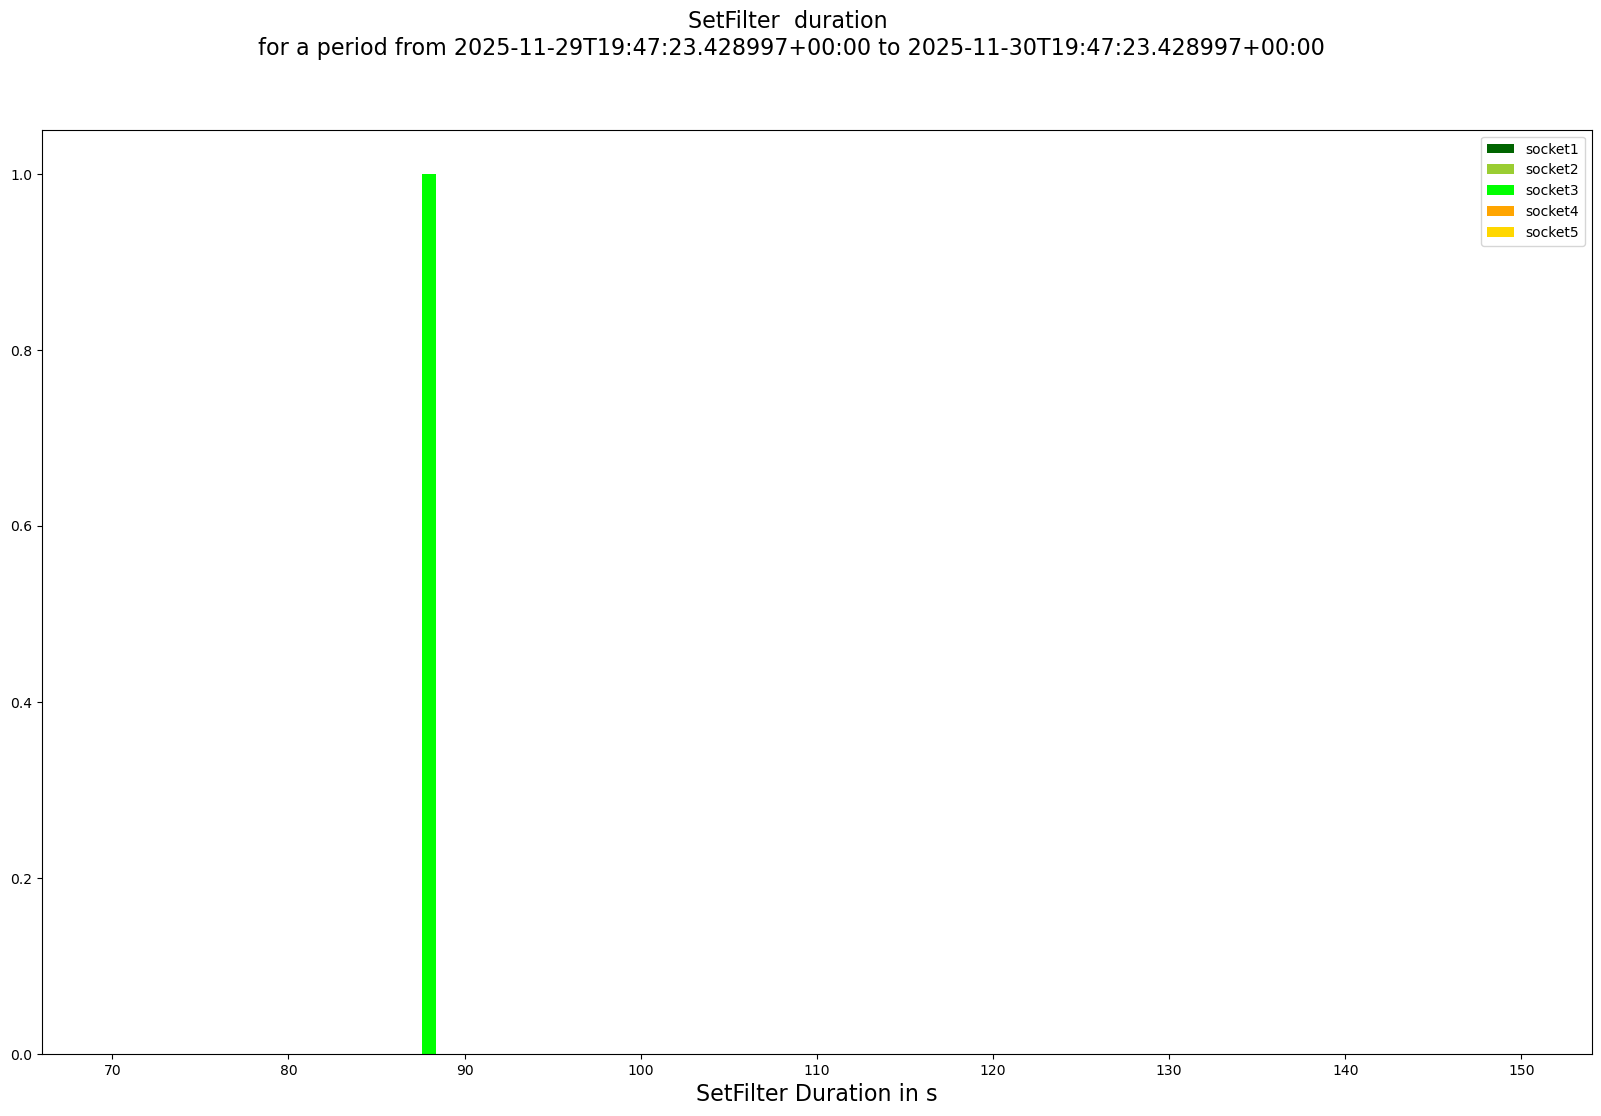

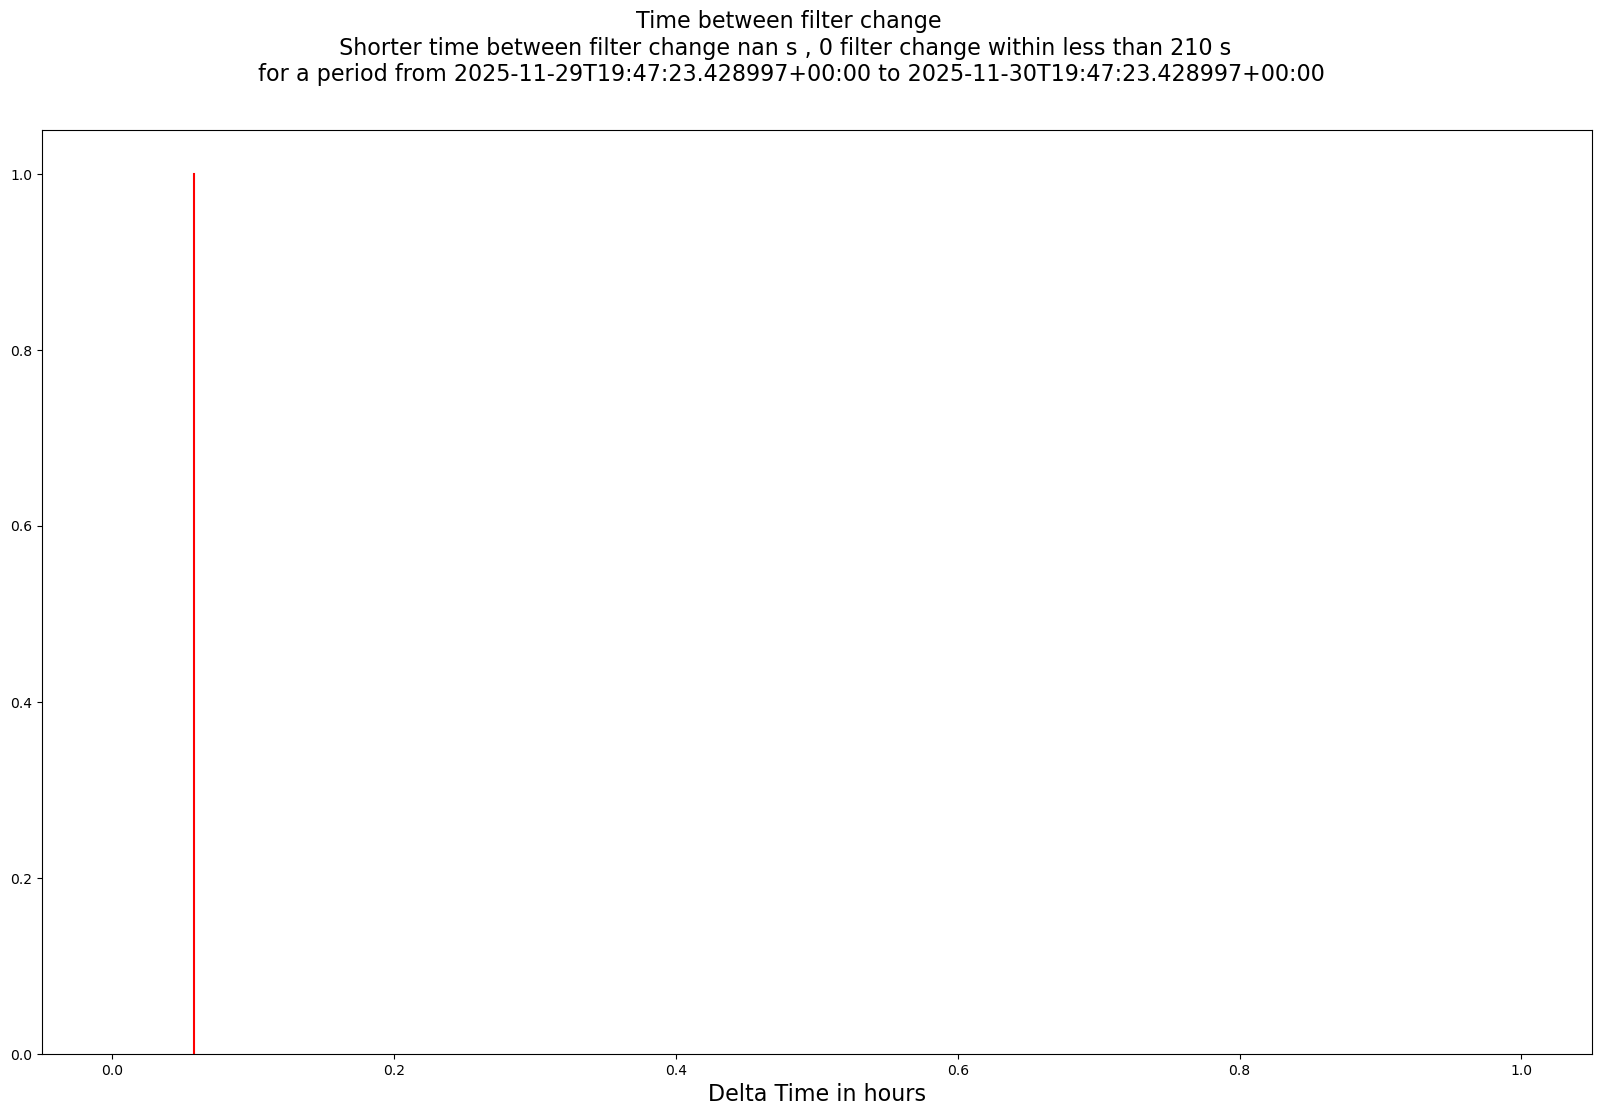

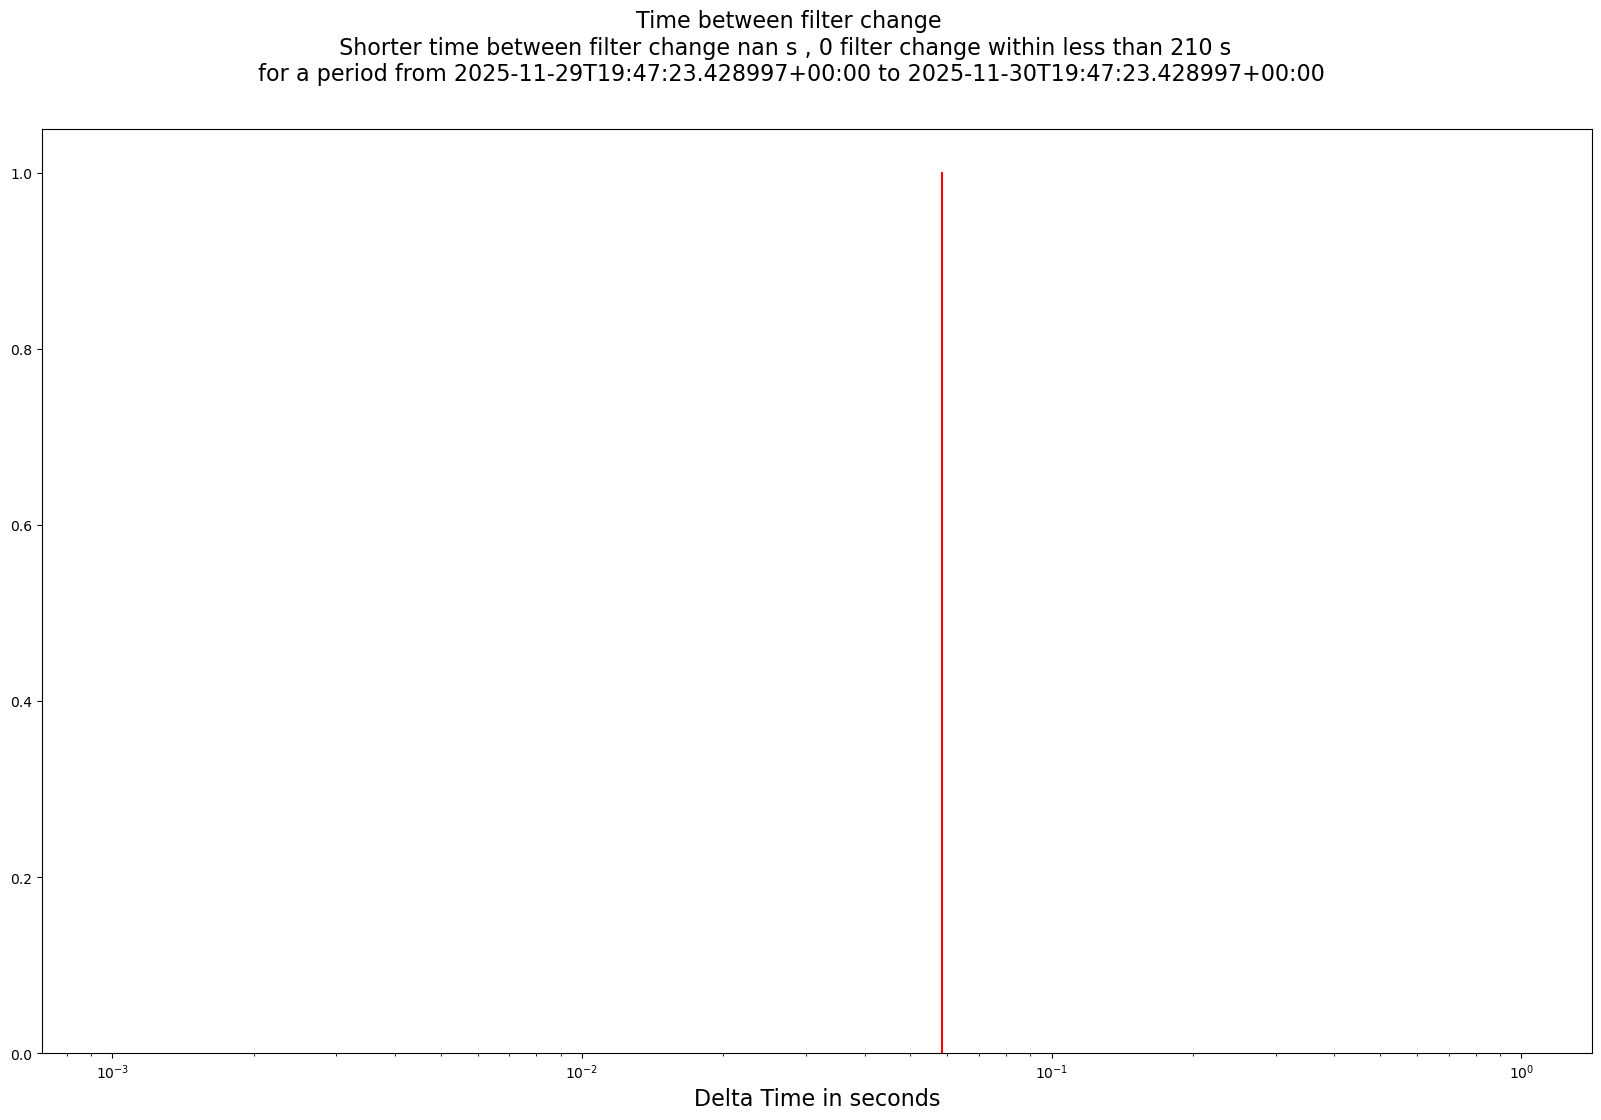

In [21]:
# Delta time between filter change
time_start=duration_all[(duration_all['UNLOCK'].notnull())& (cl_duration['Clamp']=='Xplus') ]['SET_FILTER_count'].index
nb_change=len(time_start)
delta_change=time_start[1:]-time_start[0:-1]
min_TimeChange=delta_change.min().total_seconds()
min_allowed=90+120
nb_changem3s=np.sum(delta_change.total_seconds()<min_allowed)
min_allowed_h=(min_allowed)/3600.
#
fig=plt.figure(figsize=(20,12))
title='SetFilter  duration \n for a period from %s to %s ' % (tstart,tend)
fig.suptitle(title,fontsize=16)
a=[]
label=[]
for isock in range(1,6) : 
    for car_clamp in ['Xminus'] :
        a.append(duration_all[(duration_all['UNLOCK'].notnull()) & (duration_all['Socket']==socket_name[isock-1] )& (duration_all['Clamp']==car_clamp )]['SET_FILTER']/1000.)
        label.append(socket_name[isock-1])
plt.hist(a,100,range=(70,150),stacked=True,color=color[car_clamp],label=label)
plt.xlabel('SetFilter Duration in s',fontsize=16) 
plt.legend()
if show_it : plt.show()
if save_fig : SaveFig(fig,File='SetFilterDurationHist',run_cur=run_cur,raft_cur='ClampOnCarousel')
#
if len(time_start)>1 :
    fig=plt.figure(figsize=(20,12))
    title='Time between filter changes \n Shorter time between filter change %f s , %d filter change within less than %d s   \n for a period from %s to %s ' % (min_TimeChange,nb_changem3s,min_allowed,tstart,tend)
    fig.suptitle(title,fontsize=16)
    plt.plot(time_start[1:],delta_change.total_seconds()/3600,'+')
    plt.plot([time_start[1],time_start[-1]],[min_allowed_h,min_allowed_h],'r')
    plt.ylabel('Delta Time in hours',fontsize=16)
    plt.xlabel('Date of the 2nd filter change',fontsize=16)
    plt.yscale('log')
    if show_it  : plt.show()
    if save_fig : SaveFig(fig,File='SetFilterCount',run_cur=run_cur,raft_cur='ClampOnCarousel')
    fig=plt.figure(figsize=(20,12))
    title='Time between filter change \n Shorter time between filter change %f s , %d filter change within less than %d s   \n for a period from %s to %s ' % (min_TimeChange,nb_changem3s,min_allowed,tstart,tend)
    fig.suptitle(title,fontsize=16)
    plt.hist(delta_change.total_seconds()/3600,100)
    #plt.plot([time_start[1],time_start[-1]],[min_allowed_h,min_allowed_h],'r')
    plt.xlabel('Delta Time in hours',fontsize=16)
    plt.plot([min_allowed_h,min_allowed_h],[0,1],'r')
    
    #plt.xscale('log')
    if show_it  : plt.show()
    if save_fig : SaveFig(fig,File='SetFilterCountHist',run_cur=run_cur,raft_cur='ClampOnCarousel')
    fig=plt.figure(figsize=(20,12))
    title='Time between filter change \n Shorter time between filter change %f s , %d filter change within less than %d s   \n for a period from %s to %s ' % (min_TimeChange,nb_changem3s,min_allowed,tstart,tend)
    fig.suptitle(title,fontsize=16)
    plt.hist(delta_change.total_seconds(),1000)
    #plt.plot([time_start[1],time_start[-1]],[min_allowed_h,min_allowed_h],'r')
    plt.xlabel('Delta Time in seconds',fontsize=16)
    plt.plot([min_allowed_h,min_allowed_h],[0,1],'r')
    
    plt.xscale('log')
    if show_it  : plt.show()
    if save_fig : SaveFig(fig,File='SetFilterCountHistSeconds',run_cur=run_cur,raft_cur='ClampOnCarousel')